In [6]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np



from loss import MonodepthLoss
from data_loader import prepare_dataloader


In [11]:
class conv(nn.Module):
    def __init__(self, num_in_layers, num_out_layers, kernel_size, stride):
        super(conv, self).__init__()
        self.kernel_size = kernel_size
        self.conv_base = nn.Conv2d(num_in_layers, num_out_layers, kernel_size=kernel_size, stride=stride)
        self.normalize = nn.BatchNorm2d(num_out_layers)

    def forward(self, x):
        p = int(np.floor((self.kernel_size-1)/2))
        p2d = (p, p, p, p)
        x = self.conv_base(F.pad(x, p2d))
        x = self.normalize(x)
        return F.elu(x, inplace=True)


class convblock(nn.Module):
    def __init__(self, num_in_layers, num_out_layers, kernel_size):
        super(convblock, self).__init__()
        self.conv1 = conv(num_in_layers, num_out_layers, kernel_size, 1)
        self.conv2 = conv(num_out_layers, num_out_layers, kernel_size, 2)

    def forward(self, x):
        x = self.conv1(x)
        return self.conv2(x)


class maxpool(nn.Module):
    def __init__(self, kernel_size):
        super(maxpool, self).__init__()
        self.kernel_size = kernel_size

    def forward(self, x):
        p = int(np.floor((self.kernel_size-1) / 2))
        p2d = (p, p, p, p)
        return F.max_pool2d(F.pad(x, p2d), self.kernel_size, stride=2)


class resconv(nn.Module):
    def __init__(self, num_in_layers, num_out_layers, stride):
        super(resconv, self).__init__()
        self.num_out_layers = num_out_layers
        self.stride = stride
        self.conv1 = conv(num_in_layers, num_out_layers, 1, 1)
        self.conv2 = conv(num_out_layers, num_out_layers, 3, stride)
        self.conv3 = nn.Conv2d(num_out_layers, 4*num_out_layers, kernel_size=1, stride=1)
        self.conv4 = nn.Conv2d(num_in_layers, 4*num_out_layers, kernel_size=1, stride=stride)
        self.normalize = nn.BatchNorm2d(4*num_out_layers)

    def forward(self, x):
        # do_proj = x.size()[1] != self.num_out_layers or self.stride == 2
        do_proj = True
        shortcut = []
        x_out = self.conv1(x)
        x_out = self.conv2(x_out)
        x_out = self.conv3(x_out)
        if do_proj:
            shortcut = self.conv4(x)
        else:
            shortcut = x
        return F.elu(self.normalize(x_out + shortcut), inplace=True)

    
def resblock(num_in_layers, num_out_layers, num_blocks, stride):
    layers = []
    layers.append(resconv(num_in_layers, num_out_layers, stride))
    for i in range(1, num_blocks - 1):
        layers.append(resconv(4 * num_out_layers, num_out_layers, 1))
    layers.append(resconv(4 * num_out_layers, num_out_layers, 1))
    return nn.Sequential(*layers)


class upconv(nn.Module):
    def __init__(self, num_in_layers, num_out_layers, kernel_size, scale):
        super(upconv, self).__init__()
        self.scale = scale
        self.conv1 = conv(num_in_layers, num_out_layers, kernel_size, 1)

    def forward(self, x):
        x = nn.functional.interpolate(x, scale_factor=self.scale, mode='bilinear', align_corners=True)
        return self.conv1(x)


class get_disp(nn.Module):
    def __init__(self, num_in_layers):
        super(get_disp, self).__init__()
        self.conv1 = nn.Conv2d(num_in_layers, 2, kernel_size=3, stride=1)
        self.normalize = nn.BatchNorm2d(2)
        self.sigmoid = torch.nn.Sigmoid()

    def forward(self, x):
        p = 1
        p2d = (p, p, p, p)
        x = self.conv1(F.pad(x, p2d))
        x = self.normalize(x)
        return 0.3 * self.sigmoid(x)


class Resnet50_md(nn.Module):
    def __init__(self, num_in_layers):
        super(Resnet50_md, self).__init__()
        # encoder
        self.conv1 = conv(num_in_layers, 64, 7, 2)  # H/2  -   64D
        self.pool1 = maxpool(3)  # H/4  -   64D
        self.conv2 = resblock(64, 64, 3, 2)  # H/8  -  256D
        self.conv3 = resblock(256, 128, 4, 2)  # H/16 -  512D
        self.conv4 = resblock(512, 256, 6, 2)  # H/32 - 1024D
        self.conv5 = resblock(1024, 512, 3, 2)  # H/64 - 2048D

        # decoder
        self.upconv6 = upconv(2048, 512, 3, 2)
        self.iconv6 = conv(1024 + 512, 512, 3, 1)

        self.upconv5 = upconv(512, 256, 3, 2)
        self.iconv5 = conv(512+256, 256, 3, 1)

        self.upconv4 = upconv(256, 128, 3, 2)
        self.iconv4 = conv(256+128, 128, 3, 1)
        self.disp4_layer = get_disp(128)

        self.upconv3 = upconv(128, 64, 3, 2)
        self.iconv3 = conv(64+64+2, 64, 3, 1)
        self.disp3_layer = get_disp(64)

        self.upconv2 = upconv(64, 32, 3, 2)
        self.iconv2 = conv(32+64+2, 32, 3, 1)
        self.disp2_layer = get_disp(32)

        self.upconv1 = upconv(32, 16, 3, 2)
        self.iconv1 = conv(16+2, 16, 3, 1)
        self.disp1_layer = get_disp(16)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.xavier_uniform_(m.weight)

    def forward(self, x):
        # encoder
        x1 = self.conv1(x)
        x_pool1 = self.pool1(x1)
        x2 = self.conv2(x_pool1)
        x3 = self.conv3(x2)
        x4 = self.conv4(x3)
        x5 = self.conv5(x4)

        # skips
        skip1 = x1
        skip2 = x_pool1
        skip3 = x2
        skip4 = x3
        skip5 = x4

        # decoder
        upconv6 = self.upconv6(x5)
        concat6 = torch.cat((upconv6, skip5), 1)
        iconv6 = self.iconv6(concat6)

        upconv5 = self.upconv5(iconv6)
        concat5 = torch.cat((upconv5, skip4), 1)
        iconv5 = self.iconv5(concat5)

        upconv4 = self.upconv4(iconv5)
        concat4 = torch.cat((upconv4, skip3), 1)
        iconv4 = self.iconv4(concat4)
        self.disp4 = self.disp4_layer(iconv4)
        self.udisp4 = nn.functional.interpolate(self.disp4, scale_factor=2, mode='bilinear', align_corners=True)

        upconv3 = self.upconv3(iconv4)
        concat3 = torch.cat((upconv3, skip2, self.udisp4), 1)
        iconv3 = self.iconv3(concat3)
        self.disp3 = self.disp3_layer(iconv3)
        self.udisp3 = nn.functional.interpolate(self.disp3, scale_factor=2, mode='bilinear', align_corners=True)

        upconv2 = self.upconv2(iconv3)
        concat2 = torch.cat((upconv2, skip1, self.udisp3), 1)
        iconv2 = self.iconv2(concat2)
        self.disp2 = self.disp2_layer(iconv2)
        self.udisp2 = nn.functional.interpolate(self.disp2, scale_factor=2, mode='bilinear', align_corners=True)

        upconv1 = self.upconv1(iconv2)
        concat1 = torch.cat((upconv1, self.udisp2), 1)
        iconv1 = self.iconv1(concat1)
        self.disp1 = self.disp1_layer(iconv1)
        return self.disp1, self.disp2, self.disp3, self.disp4


In [12]:
n_img, data_loader = prepare_dataloader('../../data/kitti', mode='train', batch_size=2)

Use a dataset with 108 images


In [13]:
#device = 'cuda:0'

model = Resnet50_md(num_in_layers=3)
model = model.to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-4)

md_loss = MonodepthLoss()

for epoch in range(10):
    for batch in data_loader:
        left, right = data['left_image'], data['right_image']
        left = left.to(device)
        right = right.to(device)
        optimizer.zero_grad()
        d1, d2, d3, d4 = model(left)
        loss = md_loss((d1, d2, d3, d4), (left, right))
        loss.backward()
        optimizer.step()


RuntimeError: Cannot initialize CUDA without ATen_cuda library. PyTorch splits its backend into two shared libraries: a CPU library and a CUDA library; this error has occurred because you are trying to use some CUDA functionality, but the CUDA library has not been loaded by the dynamic linker for some reason.  The CUDA library MUST be loaded, EVEN IF you don't directly use any symbols from the CUDA library! One common culprit is a lack of -Wl,--no-as-needed in your link arguments; many dynamic linkers will delete dynamic library dependencies if you don't depend on any of their symbols.  You can check if this has occurred by using ldd on your binary to see if there is a dependency on *_cuda.so library.

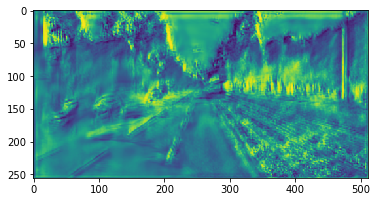

In [14]:
import matplotlib.pyplot as plt

data = next(iter(data_loader))
left, right = data['left_image'], data['right_image']

d1, d2, d3, d4 = model(left)
plt.imshow(d1.detach().cpu().numpy()[0, 1])
plt.show()

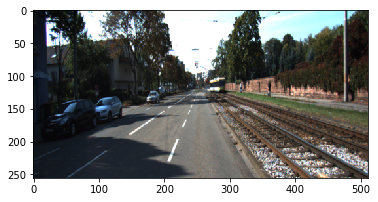

In [15]:
plt.imshow(left.detach().cpu().numpy()[0].transpose((1,2,0)))
plt.show()